<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Import-libraries-and-database" data-toc-modified-id="Import-libraries-and-database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries and database</a></span></li><li><span><a href="#Tokenize" data-toc-modified-id="Tokenize-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize</a></span></li><li><span><a href="#Eliminating-stop-words" data-toc-modified-id="Eliminating-stop-words-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eliminating stop words</a></span></li><li><span><a href="#Sentiment-analysis" data-toc-modified-id="Sentiment-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sentiment analysis</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

## Intro

We can use sentiment analysis libraries to see if the language used in South Park is conisdered to be negative or positive. We know the show is seen as a very rude show, so I would expect that, on average, the language has negative connotations.

## Import libraries and database

In [1]:
%config Completer.use_jedi = False

In [21]:
import pandas as pd
import numpy as np

#regex
import re

#NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# mongo
from pymongo import MongoClient
client = MongoClient()

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# sys
import sys
sys.path.append('../helpers')

# tqdm
from tqdm import tqdm

from mongoConnection import *

In [3]:
db = client.api_sentiment_project

In [4]:
res = read_coll("messages", {})

In [5]:
data = pd.DataFrame(res)

In [6]:
data.head()

,_id,season,episode,character,line
0,6032914c0df3816c051b703a,10,1,Stan,"You guys, you guys! Chef is going away."
1,6032914c0df3816c051b703b,10,1,Kyle,Going away? For how long?
2,6032914c0df3816c051b703c,10,1,Stan,Forever.
3,6032914c0df3816c051b703d,10,1,Chef,I'm sorry boys.
4,6032914c0df3816c051b703e,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [7]:
data = data.drop("_id", axis=1)

## Tokenize

Once we have a df with all the lines we want to analyze, we need to tokenize each word in each line to convert them in words that nltk understands

In [8]:
#Donwload tokenizer from NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alfredodezavala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
def tokenize(string):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(string)
    return tokens

In [10]:
tqdm.pandas(desc="my bar!")

In [11]:
data['line'] = data['line'].progress_apply(tokenize)
data.head()

my bar!: 100%|██████████| 70879/70879 [00:01<00:00, 55938.41it/s]


,season,episode,character,line
0,10,1,Stan,"[You, guys, you, guys, Chef, is, going, away]"
1,10,1,Kyle,"[Going, away, For, how, long]"
2,10,1,Stan,[Forever]
3,10,1,Chef,"[I, m, sorry, boys]"
4,10,1,Stan,"[Chef, said, he, s, been, bored, so, he, joini..."


## Eliminating stop words

We now eliminate stop words (i.e. words that don't give any sentiment information) from our dataframe

In [12]:
nltk.download('stopwords') #stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alfredodezavala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def stop_words(list_):
    stop_words = set(stopwords.words('english'))
    new_list = []
    for string in list_:
        if string not in stop_words:
            new_list.append(string)
    return " ".join(new_list)

In [14]:
data.line = data.line.progress_apply(stop_words)
data.head()

my bar!: 100%|██████████| 70879/70879 [00:16<00:00, 4174.81it/s]


,season,episode,character,line
0,10,1,Stan,You guys guys Chef going away
1,10,1,Kyle,Going away For long
2,10,1,Stan,Forever
3,10,1,Chef,I sorry boys
4,10,1,Stan,Chef said bored joining group called Super Adv...


## Sentiment analysis

We are now ready to use nltk to carry out the sentiment analysis

In [15]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alfredodezavala/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
def sentimentAnalysis(sentence):
    sia = SentimentIntensityAnalyzer()
    polarity = sia.polarity_scores(sentence)
    pol = polarity['compound']
    return pol

In [17]:
data['sentiment_compound'] = data.line.progress_apply(sentimentAnalysis)
data.head()

my bar!: 100%|██████████| 70879/70879 [09:53<00:00, 119.35it/s]


,season,episode,character,line,sentiment_compound
0,10,1,Stan,You guys guys Chef going away,0.0000
1,10,1,Kyle,Going away For long,0.0000
2,10,1,Stan,Forever,0.0000
3,10,1,Chef,I sorry boys,-0.0772
4,10,1,Stan,Chef said bored joining group called Super Adv...,0.6249


## Visualization

We can now use visualization to analyze the sentiment analysis results

In [18]:
data.head()

,season,episode,character,line,sentiment_compound
0,10,1,Stan,You guys guys Chef going away,0.0000
1,10,1,Kyle,Going away For long,0.0000
2,10,1,Stan,Forever,0.0000
3,10,1,Chef,I sorry boys,-0.0772
4,10,1,Stan,Chef said bored joining group called Super Adv...,0.6249


In [19]:
sent_by_season = data.groupby("season").mean().filter(["sentiment_compound"])

([<matplotlib.axis.XTick at 0x7ff19fed09a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

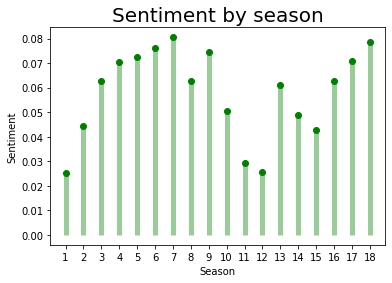

In [22]:
x = np.arange(1,19)
fig, ax = plt.subplots(1, 1)
ax.plot(x, sent_by_season["sentiment_compound"], 'go')
ax.vlines(x, 0, sent_by_season["sentiment_compound"], colors='g', lw=5, alpha=0.4)

plt.title('Sentiment by season', size=20)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.xticks(range(1,19))

It seems like there is significant variation in the sentiment from season to season. However, the show continues to use somewhat positive language overall throughout every season.

Let's look at particular characters to see if this continues to be true. We'll take a look at the top 10 characters with most lines in the show

In [23]:
n = 10
popular_characters = data['character'].value_counts()[:n].index.tolist()
popular_characters

['Cartman',
 'Stan',
 'Kyle',
 'Butters',
 'Randy',
 'Mr. Garrison',
 'Chef',
 'Kenny',
 'Sharon',
 'Mr. Mackey']

In [24]:
sent_by_character = data.groupby("character").mean().filter(["sentiment_compound"]).reset_index()

In [25]:
top_10_hist_characters = sent_by_character[sent_by_character['character'].isin(popular_characters)]

<AxesSubplot:xlabel='character'>

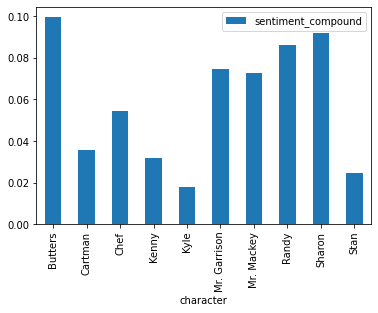

In [26]:
top_10_hist_characters.plot(kind='bar',x='character',y='sentiment_compound')

Again, while there is some variation between chatacters, it seems like the most popular characters in the show use positive language on average. We can look at how this data evolves by season, at least for the top 5

In [27]:
sentiment_char_seas = data.groupby(["season", "character"]).mean().filter(["sentiment_compound"]).reset_index()

In [28]:
n = 5
top5_popular_characters = data['character'].value_counts()[:n].index.tolist()
top5_popular_characters

['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy']

In [29]:
top_5_hist_characters = sentiment_char_seas[sentiment_char_seas['character'].isin(top5_popular_characters)]

In [30]:
top_5_hist_characters

,season,character,sentiment_compound
33,1,Cartman,-0.066780
111,1,Kyle,0.006186
178,1,Randy,0.065310
209,1,Stan,0.006883
303,2,Butters,0.000000
...,...,...,...
6312,18,Butters,0.056999
6316,18,Cartman,0.055210
6397,18,Kyle,0.065814
6463,18,Randy,0.113387


In [31]:
number_seasons = top_5_hist_characters["season"].max()

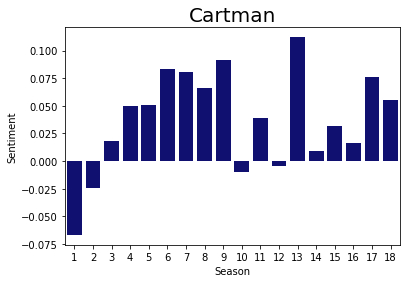

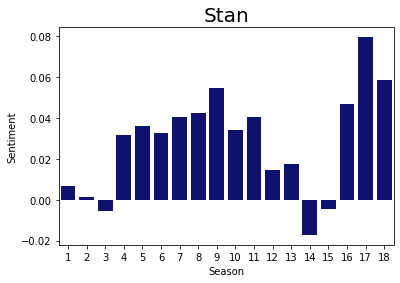

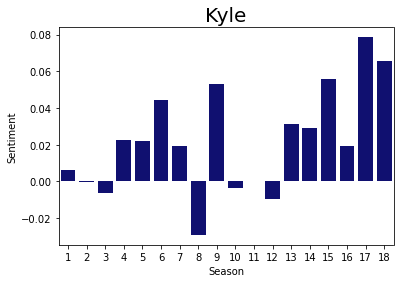

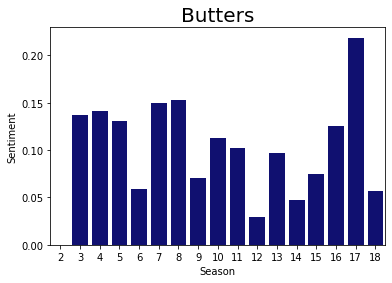

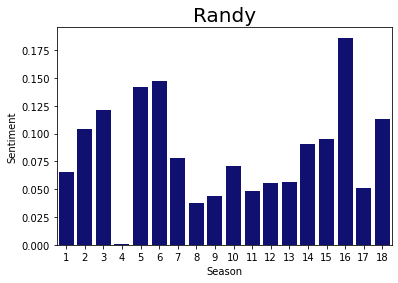

In [32]:
for char in top5_popular_characters:
    filt = top_5_hist_characters[top_5_hist_characters["character"] == char]
    sns.barplot(x = filt.season, y = filt.sentiment_compound, color = "navy")
    plt.title(char, size=20)
    plt.xlabel('Season')
    plt.ylabel('Sentiment')
    plt.show()

At last we have found characters that have an average sentiment below zero. However, we can see that there is a variability between seasons.

## Conclusions

Surprinsngly (at least for me), my initial hypothesis seems to be wrong. South Park's rudeness comes hand in hand with a relatively neutral-positive language (on average) instead of the predominance of negative language that I expected. This might be one of the secrets of a show that has been running for many seasons, as the use of a relatively positive language might leave the viewer with a general good-feel.